## Initialisation

### Dependencies

#### Third party

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#### Personal notebook

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    ifile,
    ofile,
    OUTPUT_DIR,
    PROJECT_NAME,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    dash,
)

true_strain = []
true_stress = []
for i in range(len(OUTPUT_DIR)):
    if (os.path.exists(f'{OUTPUT_DIR[i]}/true_strain_vs_true_stress.csv')):
        df = pd.read_csv(f'{OUTPUT_DIR[i]}/true_strain_vs_true_stress.csv', sep=',', names=['x','y'])
        true_strain.append(df['x'].to_numpy())
        true_stress.append(df['y'].to_numpy())
else:
    from ipynb.fs.full.true_strain_stress import (
        true_stress,
        true_strain,
    )

true_plastic_strain = []
for i in range(len(OUTPUT_DIR)):
    if (os.path.exists(f'{OUTPUT_DIR[i]}/true_plastic_strain_vs_true_stress.csv')):
        df = pd.read_csv(f'{OUTPUT_DIR[i]}/true_plastic_strain_vs_true_stress.csv', sep=',', names=['x','y'])
        true_plastic_strain.append(df['x'].to_numpy())
else:
    from ipynb.fs.full.true_strain_stress import (
        true_plastic_strain,
    )

yield_strength = [i.get_parameter('yield_strength') for i in ifile]
if yield_strength is None:
    from ipynb.fs.full.engineering_strain_stress import (
        yield_strength,
    )

An index file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): 
An index file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): 
An output file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): 
An output file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): 


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \: or \: \frac{d\sigma}{d\epsilon} \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Fitting hollomon equation to true stress-true strain data

### Computing work hardening exponent

There are two ways to compute it:
1. Fitting hollomon equation to experimental data
2. Taking $ log $ on both sides of the hollomon equation

### Hollomon Equation

$ \sigma = K \cdot \epsilon^n $

#### Method 1

Do you want to provide initial guess for K and n? (Y/n): 


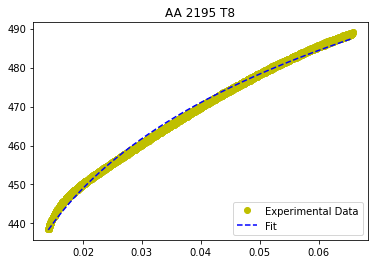

Strength coefficient (K): 588.2684516792956
Work hardening exponent (n): 0.06905069157962886
Do you want to provide initial guess for K and n? (Y/n): 


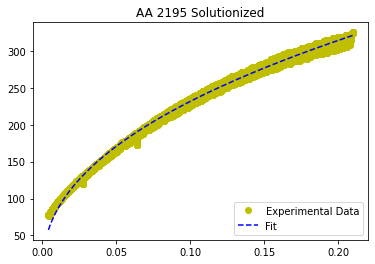

Strength coefficient (K): 638.1380185700762
Work hardening exponent (n): 0.4402230942748108


In [3]:
def fit_hollomon(x, K, n):
        return K*(x**n)

for i in range(len(true_strain)):

    choose = input('Do you want to provide initial guess for K and n? (Y/n): ')

    p0=None

    if choose in ['Y', 'y']:
        initial_guess_n = float(input("Intial guess of work hardening exponent (0 < n < 1): "))
        initial_guess_K = float(input("Intial guess of strength coefficient (MPa): "))
        p0 = (initial_guess_K, initial_guess_n)


    rhs_theoretical_hollomon = curve_fit(
        fit_hollomon, true_strain[i], true_stress[i], p0, method='lm',
    )
    popt, _ = rhs_theoretical_hollomon
    K = popt[0]
    n = popt[1]

    fig, ax = plt.subplots(1,1)
    _ = ax.plot(true_strain[i], true_stress[i], 'yo')
    _ = ax.plot(true_strain[i], [fit_hollomon(pl,K,n) for pl in true_strain[i]], 'b--')

    if choose in ['Y', 'y']:
        _ = ax.plot(true_strain[i], [fit_hollomon(pl,initial_guess_K,initial_guess_n) for pl in true_strain[i]], 'g:',)
        _ = ax.legend(['Experimental Data','Guess', 'Fit'], loc='lower right')

    _ = ax.legend(['Experimental Data','Fit'], loc='lower right')
    ax.set_title(PROJECT_NAME[i])

    _ = fig.savefig(f'{OUTPUT_DIR[i]}/Hollomon curve', facecolor='white', transparent=True)
    
    plt.show()

    print(f'Strength coefficient (K): {K}')
    print(f'Work hardening exponent (n): {n}')

    if ifile[i].add_parameter('K_M1', K):
        ofile[i].save_parameter('Strength coefficient (K) (M1)', K, 'MPa')

    if ifile[i].add_parameter('n_M1', n):
        ofile[i].save_parameter('Work hardening exponent (n) (M1)', n, '')

#### Method 2

$ \sigma = K \cdot \epsilon^n \Rightarrow $ 
$ log(\sigma) = logK + nlog\epsilon $

In [4]:
log_true_stress = [np.log(i) for i in true_stress]
log_true_strain = [np.log(i) for i in true_strain]

for i in range(len(log_true_strain)):
    model = LinearRegression().fit(log_true_strain[i].reshape(-1,1), log_true_stress[i])
    coef = model.score(log_true_strain[i].reshape(-1,1), log_true_stress[i])
    work_hard_exp = model.coef_[0]
    strenght_coefficient = np.exp(model.intercept_)
    
    print(dash(PROJECT_NAME[i]))
    print(f'Work hardening exponent: {work_hard_exp}')
    print(f'Strength coefficient: {strenght_coefficient}')
    print(f'Accuracy in calculations: {coef}')

    if ifile[i].add_parameter('K_M2', K):
        ofile[i].save_parameter('Strength coefficient (K) (M2)', K, 'MPa')

    if ifile[i].add_parameter('n_M2', work_hard_exp):
        ofile[i].save_parameter('Work hardening exponent (n) (M2)', n, '')

--------------------AA 2195 T8--------------------
Work hardening exponent: 0.06876901046365227
Strength coefficient: 587.723124417405
Accuracy in calculations: 0.9934822694044504
---------------AA 2195 Solutionized---------------
Work hardening exponent: 0.42145909459290437
Strength coefficient: 611.5399044893053
Accuracy in calculations: 0.9910748116519768


## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\epsilon$

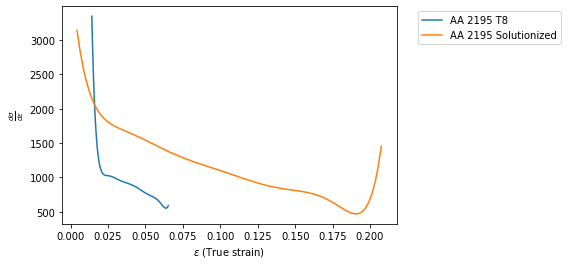

In [8]:
fig, ax = plt.subplots(1,1)

reduced_true_strain = []
reduced_true_stress = []
d_sigma_epsilon = []

for i in range(len(true_strain)):
    true_stress_smooth_coeff = np.polyfit(true_strain[i], true_stress[i], 9)

    consider = 101

    reduced_true_strain.append(np.linspace(min(true_strain[i]),max(true_strain[i]),consider))
    reduced_true_stress.append(np.polyval(true_stress_smooth_coeff, reduced_true_strain[i]))

    d_sigma_epsilon.append(differentiate(reduced_true_strain[i], reduced_true_stress[i]))

    ax.plot(reduced_true_strain[i][:consider-1], d_sigma_epsilon[i])
    ax.set_xlabel('$\epsilon$ (True strain)')
    ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

    fig.savefig(f'{OUTPUT_DIR[i]}/Work hardening rate vs true strain', facecolor='white', transparent=False)

    pd.DataFrame(
        np.transpose(np.asarray([reduced_true_strain[i][:consider-1], d_sigma_epsilon[i]], dtype=object))
    ).to_csv(f'{OUTPUT_DIR[i]}/true_strain_vs_work_hardening_rate.csv', index=False, header=False)

_ = ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))

Roger Lumley, *Fundamentals of Aluminium Metallurgy: Production, Processing and Applications*, 2011, Page No 311

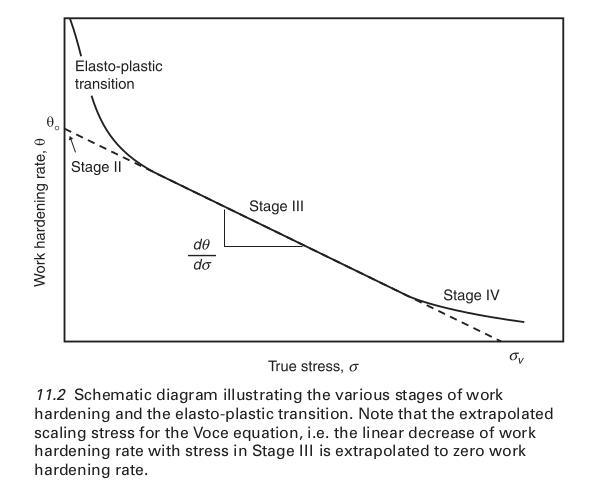

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\frac{\sigma}{\epsilon}$

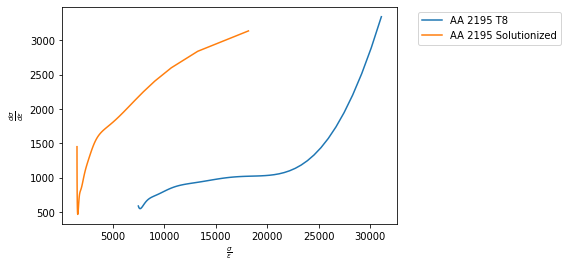

In [9]:
fig, ax = plt.subplots(1,1)

for i in range(len(reduced_true_stress)):
    sigma_epsilon = np.true_divide(reduced_true_stress[i], reduced_true_strain[i])

    ax.plot(sigma_epsilon[:consider-1], d_sigma_epsilon[i])
    ax.set_xlabel('$\\frac{\sigma}{\epsilon}$')
    ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

_ = ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\sigma - \sigma_{ys}$

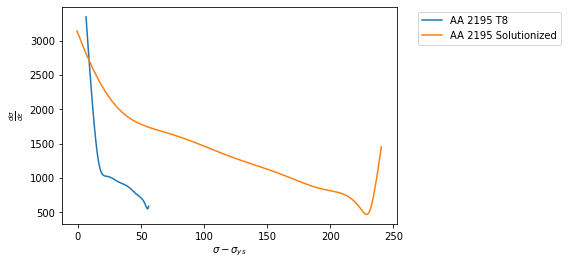

In [12]:
fig, ax = plt.subplots(1,1)

for i in range(len(reduced_true_stress)):
    reduced_flow_stress = np.subtract(reduced_true_stress[i], float(yield_strength[i]))
    ax.plot(reduced_flow_stress[:consider-1], d_sigma_epsilon[i])
    ax.set_xlabel('$\sigma - \sigma_{ys}$')
    ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

_ = ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))

## Plot of $\sigma - \sigma_{ys}$ v/s $\epsilon$

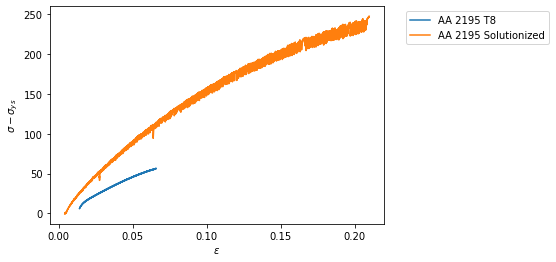

In [13]:
fig, ax = plt.subplots(1,1)

for i in range(len(true_strain)):
    ax.plot(true_strain[i], np.subtract(true_stress[i], float(yield_strength[i])))
    ax.set_ylabel('$\sigma - \sigma_{ys}$')
    ax.set_xlabel('$\epsilon$')

_ = ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))